In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os, argparse

### Data Cleaning Workflow

1. **Read the Original Processor Dataset**:
    - The dataset contains various details about processors, including:
      - Product Type
      - Processor Name
      - Process Node
      - Die Area
      - TDP
      - GFLOPS
      - Release Date
      - Vendor
      - Manufacturing 
      - Frequency(GHz)

2. **Clean Up the Dataset**:
    - Remove unnecessary columns and keep only the relevant ones: *Processor Type, Name, Node, Die Area, TDP*

3. **Filter OutProcessors**:
    - Currently, **ECO-CHIP** and **CarbonSet** only supports monolithic chips, we partition the processors into *monolithic* and *chiplet* processors.
    - We further partition the GPUs and CPUs to separate datasets.

In [2]:
original_processors = pd.read_excel("DataSetWithRelaventNodesArea.xlsx")
# Define columns to check for missing/zero values (excluding GFLOPS columns)
columns_to_check = [col for col in original_processors.columns if 'GFLOPS' not in col]
# Replace zero values with NaN for non-GFLOPS columns
original_processors[columns_to_check] = original_processors[columns_to_check].replace([0,'unknown'], np.nan, )
# Drop rows with any NaN values in the specified columns
cleaned_processors = original_processors.dropna(subset=columns_to_check)
cleaned_processors = cleaned_processors.drop(columns=[col for col in cleaned_processors.columns if 'GFLOPS' in col])

/var/folders/m8/b_2080mx7_g7rw0h0twjfqk00000gn/T/ipykernel_66868/2234529275.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  original_processors[columns_to_check] = original_processors[columns_to_check].replace([0,'unknown'], np.nan, )


In [3]:
cleaned_processors

,Product,Type,Release Date,Process Size (nm),TDP (W),DieSizeValue,Die Size (mm^2),Transistors (million),Freq (GHz),Foundry,Vendor
15,Intel Core i5-3335S,CPU,2012-11-01,22.0,65.0,160.0,160,1480.0,2700.0,Intel,Intel
18,Intel Core i7-3525M,CPU,2012-11-01,22.0,35.0,160.0,160,1480.0,2900.0,Intel,Intel
19,Intel Core i7-3630QM,CPU,2012-09-30,22.0,45.0,160.0,160,1480.0,2400.0,Intel,Intel
20,Intel Core i7-3632QM,CPU,2012-10-19,22.0,35.0,160.0,160,1480.0,2200.0,Intel,Intel
21,Intel Core i7-3632QM,CPU,2012-10-19,22.0,35.0,160.0,160,1480.0,2200.0,Intel,Intel
...,...,...,...,...,...,...,...,...,...,...,...
1837,GTX TITAN Pascal,GPU,2016-01-01,14.0,250.0,471.0,471,12000.0,1417.0,TSMC,NVIDIA
1838,GTX TITAN Xp,GPU,2017-01-01,14.0,250.0,471.0,471,12000.0,1180.0,TSMC,NVIDIA
1839,GTX TITAN V,GPU,2018-01-01,14.0,250.0,815.0,815,21100.0,1200.0,TSMC,NVIDIA
1840,RTX TITAN RTX,GPU,2018-12-01,14.0,280.0,754.0,754,18600.0,1350.0,TSMC,NVIDIA


In [4]:
# Identify chiplet processors where DieSizeValue differs from Die Size
chiplet_mask = cleaned_processors['DieSizeValue'] != cleaned_processors['Die Size (mm^2)']
# Get chiplet processors
chiplet_processors = cleaned_processors[chiplet_mask]
# Get non-chiplet processors
monolithic_processors = cleaned_processors[~chiplet_mask]
chiplet_processors.to_csv("chiplet_processors.csv", index=False)
monolithic_processors.to_csv("monolithic_processors.csv", index=False)
# further partition the monolithic processors into GPUs and CPUs
gpu_processors = monolithic_processors[monolithic_processors['Type'] == 'GPU']
cpu_processors = monolithic_processors[monolithic_processors['Type'] == 'CPU']
gpu_processors.to_csv("gpus.csv", index=False)     
cpu_processors.to_csv("cpus.csv", index=False)

### Sustainable Metrics Generation for Cleaned Monolithic Chips

We can now further generate the sustainable metrics of cleaned monolithic chips in the following steps. Here we perform a **Monte-Carlo simulation** with a **Kernel Density Estimation** probabilistic model on every processor.

We have 5 semiconductor manufacturing parameters that significantly impact the overall carbon emission of processors, including:

- **Defective Density (dd)**: The ratio of actual fabricated faulty chips to functional chips, which is heavily depend on the *Process Node* applied. 
- **Gas per Area (gpa)**: The factor estimating the $CO_2$ emission per unit area.
- **Energy per Area (epa)**: The factor estimating the energy consumption per unit area. *Process Node* will also greatly impact this value.
- **Process Node (nm)**: The size of the process node in nanometers.
- **Carbon Intensity (ci)**: The sustainability estimation factor of the used energy/electricity source in terms of $CO_2$ emission per kWh.

We have detailed explanation and discussion of how the following probabilistic distribution is calculated / obtained in our paper. Please refer to the paper if any questions raised.  

In [5]:
# Generate the probabilistic modeled parameters for Carbon Footprint calculation
# Assume 10k sample size for each parameter
sample_size = 10000
carbon_intensity_distribution = [0.03125,0.03125,0.03125,0.03125,0.01041667,0.01041667,0.01041667,0.01041663,0.01041667,
                    0.01041667,0.01041667,0.01041667,0.01041667,0.01041667,0.01041667,
                    0.01041667,0.04166667,0.04166667,0.04166667,0.04166667,
                    0.02083333,0.02083333,0.02083333,0.02083333,0.0625,0.0625,
                    0.0625,0.0625,0.0625,0.0625,0.0625,0.0625]
carbon_intensity_sequence = np.random.choice(np.arange(480.8486,546.7014,2.057901), size=sample_size, replace=True, p = carbon_intensity_distribution)

gpa_mean=150
gpa_std=30

gpa_sequence = np.random.normal(gpa_mean, gpa_std, sample_size)
gpa_sequence = np.clip(gpa_sequence,50,300)


# We use the estimated reference values of defective density and EPA in very process node to model the complete sequence 
defective_density_reference =  {"7": 0.2, "10": 0.11, "14":0.09, "22": 0.08, "28":0.07, "65":0.05}
epa_reference =  {"7": 2.15, "10": 1.475, "14":1.2, "22": 1.2, "28":0.9}

epa_distribution = [0.092478422,0.09864365,
                    0.101726264,0.103575832,0.101726264,0.097410604,
                    0.091245376,0.08323058,0.073982737,0.061652281,
                    0.048088779,0.033908755,0.012330456,]

defective_density_distribution=[0.1125,0.1125,0.1125,0.1125,0.1125,0.05,0.05,0.05,0.05,0.05,
    0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,
    0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,0.0125,]

def probabilistic_model(reference, p, stride = 25, d1 = None, d2 = None):
    d1 = 0.11 - 0.095
    d2 = 0.42 - 0.11
    defect_distribution = dict()
    for node in reference:
        defect_bench = defective_density_reference[node]
        start = defect_bench - d1
        end = defect_bench + d2
        step = (end - start) / stride
        defect_distribution[node] = np.random.choice(np.arange(start, end, step), size=sample_size, replace=True, p=p)
    return defect_distribution


def highest_probability(result):
    unique_values, counts = np.unique(result, return_counts=True)
    probabilities = counts / len(result)  # Convert frequency models to probabilities
    # Find the maximum probability and its corresponding value
    max_prob_index = np.argmax(probabilities)
    max_prob_value = unique_values[max_prob_index]
    max_prob = probabilities[max_prob_index]

    return max_prob_value, max_prob


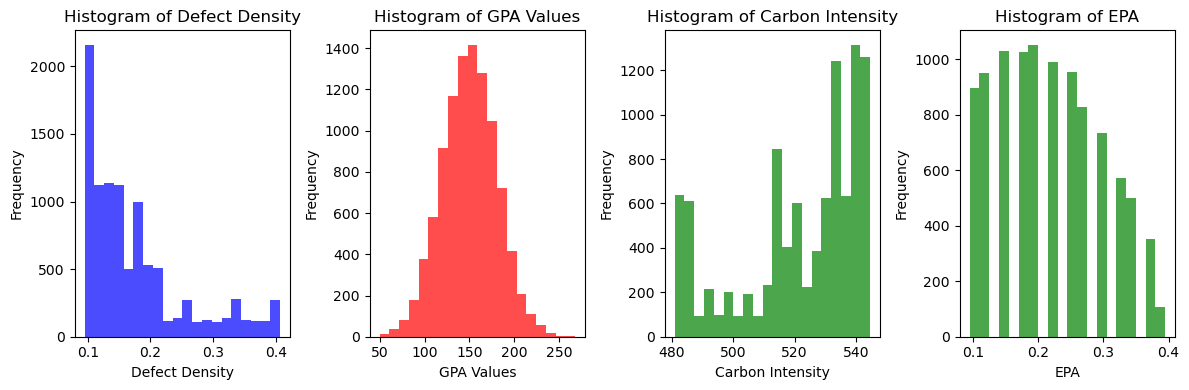

In [6]:
# lets plot the actual modeled distribution of all the parameters mentioned above with sample process node = 7nm
defective_density_sequence = probabilistic_model(defective_density_reference, defective_density_distribution)
epa_sequence = probabilistic_model(epa_reference, epa_distribution, stride = 13, d1 = 0.575, d2 = 0.025)
node = '10'
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.hist(defective_density_sequence[node], bins=20, alpha=0.7, color='b')
plt.xlabel('Defect Density')
plt.ylabel('Frequency')
plt.title('Histogram of Defect Density')

# Plot histogram for gpa_sequence
plt.subplot(1, 4, 2)
plt.hist(gpa_sequence, bins=20, alpha=0.7, color='r')
plt.xlabel('GPA Values')
plt.ylabel('Frequency')
plt.title('Histogram of GPA Values')

# Plot histogram for ci_model
plt.subplot(1, 4, 3)
plt.hist(carbon_intensity_sequence, bins=20, alpha=0.7, color='g')
plt.xlabel('Carbon Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Carbon Intensity')


plt.subplot(1, 4, 4)
plt.hist(epa_sequence[node], bins=20, alpha=0.7, color='g')
plt.xlabel('EPA')
plt.ylabel('Frequency')
plt.title('Histogram of EPA')

plt.tight_layout()
plt.show()

### Carbon Footprint Calculation using ECO-CHIP
 
[ECO-CHIP](https://github.com/ASU-VDA-Lab/ECO-CHIP) is a chip carbon footprint modeling framework based on the chip interconnect, power, area, and above 5 parameters. 
For every processor, we will calculate the minimum and maximum CFPs and eventually calculate the expected (mean) CFP value as the most representable CFP value of this processor. The min/max CFP can be directly derived using the min/max of input parameters.


In [7]:
# Add the eco_chip_enhanced folder to the system path
sys.path.append(os.path.join(os.getcwd(), "../eco_chip_enhanced/"))

# Import the eco_chip function from the eco_chip_func module
from eco_chip_func import eco_chip

def get_cfp(process_node, power, area, defective_density, gpa, carbon_intensity, epa, dir = None):
    # Calculate the Carbon Footprint (CFP) for the given processor
    if dir is None:
        dir = 'testcases/CFP_survey'
    args = argparse.Namespace(
        design_dir = dir,
        chip_area = area,
        chip_power = power,
        node = process_node,
        defect_density = defective_density,
        gpa = gpa, 
        epa = epa,
        num_lifetime=None,
        tech_scaling_path='../eco_chip_enhanced/',
        carbon_intensity = carbon_intensity
    )

    # we have design carbon, manufacturing carbon, operational carbon and total carbon
    design_carbon, mfg_carbon, ope_carbon, total_carbon = eco_chip(args)
    embodied_carbon = float(design_carbon) + float(mfg_carbon)
    operational_carbon = float(ope_carbon)
    total_carbon = float(total_carbon)
    
    return embodied_carbon, operational_carbon, total_carbon


In [8]:
def calculate_min_max_cfp():
    for idx, proc in cleaned_processors.iterrows():
        node = int(proc['Process Size (nm)'])
        power = int(proc['TDP (W)'])
        area = int(proc['DieSizeValue'])
        # calculate the minimum CFP values
        defective_density = defective_density_sequence[str(node)].min()
        epa = epa_sequence[str(node)].min()
        gpa = gpa_sequence.min()  
        carbon_intensity = carbon_intensity_sequence.min()     
        embodied_carbon_min, operational_carbon_min, total_carbon_min = get_cfp(node, power, area, defective_density, gpa, carbon_intensity, epa)
        # update the cleaned processor dataframe
        cleaned_processors.at[idx, 'Emb_Carbon_Min'] = embodied_carbon_min
        cleaned_processors.at[idx, 'Ope_Carbon_Min'] = operational_carbon_min
        cleaned_processors.at[idx, 'Tot_Carbon_Min'] = total_carbon_min
        
        # calculate the maximum CFP values
        defective_density = defective_density_sequence[str(node)].max()
        epa = epa_sequence[str(node)].max()
        gpa = gpa_sequence.max()  
        carbon_intensity = carbon_intensity_sequence.max()     
        embodied_carbon_max, operational_carbon_max, total_carbon_max = get_cfp(node, power, area, defective_density, gpa, carbon_intensity, epa)
        
        cleaned_processors.at[idx, 'Emb_Carbon_Max'] = embodied_carbon_max
        cleaned_processors.at[idx, 'Ope_Carbon_Max'] = operational_carbon_max
        cleaned_processors.at[idx, 'Tot_Carbon_Max'] = total_carbon_max

In [ ]:
# Calculate the min/max CFP values
calculate_min_max_cfp()

### Mean CFP Calculation

In this part, we will calculate the mean CFP value for every processor in our cleaned dataset. For each processor, we will calculate every possible CFP value using the combination of 5 input parameters with a size of *sample_size*. 

A good point of the *Monte-Carlo* simulation is that here, we only require *sample size* runs in total rather than *sample size^5*. Since all the input parameters are independent, iterating every permutation of these parameters has the exact same effect as just using the *sample_size* samples directly. 

Statistically speaking, every parameter sequence is generated randomly without any order. Therefore, directly combining them in a sequential manner to form a *sample_size* group of input parameters is exactly the same operation as iterating every permutation of the *sample_size^5* space. The final simulation result of the two methods will converge to a certain value with increased sample size.

**The overall runtime of mean CFP calculation will be significantly longer than the previous min/max CFP calculation. We highly suggest you follow the Monte-Carlo method we proposed here rather than using the conventional brute-force 'permutation' method, which usually takes hours to days based on our experiences.**

In [10]:
# this function will calculate the mean CFP value of every processor
def calculate_mean_cfp(idx, proc, dir = None):
    node = int(proc['Process Size (nm)'])
    power = int(proc['TDP (W)'])
    area = int(proc['DieSizeValue'])
    
    embodied_carbon_list = np.zeros(sample_size)
    operational_carbon_list = np.zeros(sample_size)
    
    for i in range(sample_size):
        emb_c, ope_c, tot_c = get_cfp(node, power, area, defective_density_sequence[str(node)][i],
                                        gpa_sequence[i], carbon_intensity_sequence[i], epa_sequence[str(node)][i], dir=dir)
        embodied_carbon_list[i] = emb_c
        operational_carbon_list[i] = ope_c
        
        
    embodied_carbon_mean = embodied_carbon_list.mean()
    operational_carbon_mean = operational_carbon_list.mean()
    total_carbon_mean = embodied_carbon_mean + operational_carbon_mean
    
    
    return idx, embodied_carbon_mean, operational_carbon_mean, total_carbon_mean        

In [11]:
import time, joblib

start = time.time()

results = joblib.Parallel(n_jobs= -1)(
    joblib.delayed(calculate_mean_cfp)(idx, proc) 
    for idx, proc in cleaned_processors.iterrows())

print(f"Execution Time: {time.time() - start:.2f} seconds")


In [12]:
for idx, emb_mean, ope_mean, tot_mean in results:
    cleaned_processors.at[idx, 'Emb_Carbon_Mean'] = emb_mean
    cleaned_processors.at[idx, 'Ope_Carbon_Mean'] = ope_mean
    cleaned_processors.at[idx, 'Tot_Carbon_Mean'] = tot_mean


cleaned_processors.to_csv("CarbonSet.csv", index=False)

### Chiplet Processor CFP Modeling

In this part, we will calculate the mean CFP value for Chiplet processors in our cleaned dataset. Ideally, chiplet processors have lower carbon emission due to their smaller single die size with higher manufacturing yield and less waste.

We follow the same procedure of modeling monolithic processors, with 2 new assumptions

**1. The total chip area is averaged across each die, which means each chiplet/separate die has exactly the same die area.**

**2. Due to the unrevealed tech parameters of each processor, we assume every chiplet is fabricated in same tech node. In other words, although practically only the compute die is fabricated using newest process node, here we assume all the chiplets/dies have the same most advanced process node**

In [14]:
chiplet_processors = pd.read_csv("chiplet_processors.csv")
chiplet_processors[['#dies','Avg Die Area']] = chiplet_processors['Die Size (mm^2)'].str.extract(r'(\d+)\s*x\s*(\d+)')

In [16]:
import json
def generate_die_json(num_of_dies: int, die_area: int, file_path: str) -> None:
    data = dict()
    # Add CPU dies based on num_of_dies
    for i in range(int(num_of_dies)):
        data[f"CPU_{i}"] = {
            "type": "logic",
            "area": int(die_area)
        }
    data["pkg_type"] = "RDL"
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "w") as json_file:
        json_file.write(json.dumps(data, indent=4))

In [17]:
def get_chiplet_cfp(idx, proc):
    dir = "../eco_chip_enhanced/chiplet_dir/"
    json_file = f"{dir}architecture.json"
    generate_die_json(proc['#dies'], proc['Avg Die Area'], json_file)
    idx, embodied_carbon_mean, operational_carbon_mean, total_carbon_mean  = calculate_mean_cfp(idx, proc, dir = dir)
    return idx, embodied_carbon_mean, operational_carbon_mean, total_carbon_mean   



In [19]:
import time, joblib

start = time.time()

results = joblib.Parallel(n_jobs= -1)(
    joblib.delayed(get_chiplet_cfp)(idx, proc) 
    for idx, proc in chiplet_processors.iterrows())

print(f"Execution Time: {time.time() - start:.2f} seconds")



Execution Time: 92.26 seconds


In [21]:
for idx, emb_mean, ope_mean, tot_mean in results:
    chiplet_processors.at[idx, 'Emb_Carbon_Mean'] = emb_mean
    chiplet_processors.at[idx, 'Ope_Carbon_Mean'] = ope_mean
    chiplet_processors.at[idx, 'Tot_Carbon_Mean'] = tot_mean

chiplet_processors.to_csv("chiplet_processors.csv", index=False)
